In [1]:
import healpy as hp
import numpy as np
import math
import pandas as pd
import seaborn as sns
from tqdm import tqdm, tqdm_notebook
from scipy.special import erf
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcdefaults()
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import colors
rcParams['mathtext.rm'] = 'Times New Roman' 
rcParams['text.usetex'] = True
rcParams['font.family'] = 'times' #'sans-serif'

font_manager.findfont('serif', rebuild_if_missing=True)
fontsize = 14
rcParams.update({'font.size':fontsize})

from my_units import * 
from angular_fn import *
from template_fn import *
from cov_matrix_fn import *

HomeDir = '../'
DataDir = HomeDir+'data/' ### Set this to the directory where you store your data files (see below how to download them)
ListDir = HomeDir+'lists/'
FigDir = HomeDir+'figures/'

# Background motion subtraction

Use the proper motion, acceleration and parallax stats histograms to subtract the mean motion from the background stars and replace the measurement errors with the effective dispersion.

## Import data and define bins for the background stars

In [2]:
stars_df = pd.read_csv(DataDir+'pairs_background_new.csv')

# Keep only stars with G mag measurement
length_before = len(stars_df)
stars_df = stars_df[~np.isnan(stars_df['phot_g_mean_mag'])]
print(length_before, len(stars_df))

4057114 4041315


In [3]:
### Parallax and G mag bin definition
bins_parallax = np.concatenate([[-1000],np.logspace(np.log10(0.05),np.log10(2),10),[1000]])
bins_G = np.arange(3,23,1) # the min and max G mag in the entire catalog are 3 and 21

### Spatial pixelation with healpy pixels at level 8 (as used in EDR3)
n = 8
fac_source_id = 2**(59-2*n) # factorization used to extract the healpy bin from the source id

In [5]:
### Get the bin index for the background stars
q_pix = np.floor(stars_df['source_id'].to_numpy() / fac_source_id).astype(int) # healpix bin

q_G = np.digitize(stars_df['phot_g_mean_mag'], bins_G)-1 # G mag bin

### Probabilistic assignment to parallax bins
stars_parallax = stars_df['parallax'].to_numpy(); stars_parallax_error = stars_df['parallax_error'].to_numpy();
prob_parallax = np.nan * np.ones((len(stars_df),len(bins_parallax)-1))
for i in range(len(bins_parallax)-1):
    x1_list = (bins_parallax[i]-stars_parallax)/stars_parallax_error/np.sqrt(2)
    x2_list = (bins_parallax[i+1]-stars_parallax)/stars_parallax_error/np.sqrt(2)
    prob_parallax[:,i] = 0.5*(erf(x2_list)-erf(x1_list))

## Get stats for each star and save result

Download proper motion and parallax stats histograms here:
https://www.dropbox.com/sh/9lk85sttj8bl6wj/AAAFQqA2mud7kpEjAvFzDLo7a?dl=0

In [6]:
### Indices of the stars in the flattened stats histogram
stars_i = q_G + q_pix*(len(bins_G)-1) 

In [7]:
### Get proper motion stats (need to loop over parallax bins)

w_pm_st = np.zeros((len(stars_df), 5)); w_pm_sum = np.zeros((len(stars_df), 5));

for i in tqdm(range(len(bins_parallax)-1)):

    hist = pd.read_csv(ListDir+'hist_stats/hist_pm_stats_'+str(0)+'.csv') # read in histogram
    hist.sort_values(['pix','G_bin'],inplace=True) # sort histogram
    stars_stat = hist.iloc[stars_i] # get stats for the stars in the list
    st = stars_stat[['mean_pmra', 'mean_pmdec', 'var_pmra', 'var_pmdec', 'var_pmradec']].to_numpy()
    no_nan_loc_to_1 = (~np.isnan(st)).astype(int) # convert to 1 non-nan elements and to 0 nan elements (to sum over weights)
    w_pm_sum += (no_nan_loc_to_1.T * prob_parallax[:, i]).T        
    st[np.isnan(st)] = 0 # replace nan values with zero
    w_pm_st += (st.T * prob_parallax[:, i]).T # weighted statistic for i-th parallax bin   
    
w_pm_st = w_pm_st/(w_pm_sum + 1E-20)

100%|██████████| 11/11 [02:51<00:00, 15.57s/it]


In [8]:
### Get parallax stats

hist = pd.read_csv(ListDir+'hist_stats/hist_par_stats.csv') # read in histogram
hist.sort_values(['pix','G_bin'],inplace=True) # sort histogram
stars_par_stat = hist.iloc[stars_i] # get stats for the stars in the list
st_par = stars_par_stat[['mean_parallax', 'parallax_error']].to_numpy()

In [9]:
### Join pm and parallax stats 
stats_df = pd.DataFrame(np.concatenate((w_pm_st, st_par), axis=1), columns=['mean_pmra', 'mean_pmdec', 'var_pmra', 'var_pmdec', 'var_pmradec', 'mean_parallax', 'parallax_error'])\
### For some stars stats info is not avaliable. Replace nan values with zero.
stats_df.replace(np.nan, 0, inplace=True)

In [10]:
len(stats_df), len(stars_df), len(w_pm_st)

(4041315, 4041315, 4041315)

In [11]:
### Add columns to the stars data fram with the subtracted quantities and the effective errors
stars_df['pmra_sub'] = stars_df['pmra'] - stats_df['mean_pmra'].to_numpy()
stars_df['pmdec_sub'] = stars_df['pmdec'] - stats_df['mean_pmdec'].to_numpy()
stars_df['parallax_sub'] = stars_df['parallax'] - stats_df['mean_parallax'].to_numpy()
stars_df['parallax_eff_error'] = stats_df['parallax_error'].to_numpy()
stars_df['pmra_eff_error'] = np.sqrt(stats_df['var_pmra'].to_numpy())
stars_df['pmdec_eff_error'] = np.sqrt(stats_df['var_pmdec'].to_numpy())

In [22]:
### For stars that do not have stats info, use the instrumental error instead of the effective error
zero_ind_pm = (stats_df['mean_pmra'].to_numpy()==0)
zero_ind_par = (stats_df['mean_parallax'].to_numpy()==0)
print(len(stats_df[zero_ind_pm]), len(stats_df[zero_ind_par]))

stars_df['pmra_eff_error'].iloc[zero_ind_pm] = stars_df['pmra_error'].iloc[zero_ind_pm]
stars_df['pmdec_eff_error'].iloc[zero_ind_pm] = stars_df['pmdec_error'].iloc[zero_ind_pm]
stars_df['parallax_eff_error'].iloc[zero_ind_par] = stars_df['parallax_error'].iloc[zero_ind_par]

80059 6341


In [23]:
### Add column for the pmra and pmdec correlation
stars_df['pmra_pmdec_eff_corr'] = stats_df['var_pmradec'].to_numpy()/(stars_df['pmra_eff_error'].to_numpy()*stars_df['pmdec_eff_error'].to_numpy())
stars_df['pmra_pmdec_eff_corr'].iloc[zero_ind_pm] = stars_df['pmra_pmdec_corr'].iloc[zero_ind_pm]

In [102]:
### Save file with the subtracted motion and effective error
stars_df.to_csv(DataDir+'pairs_background_w_st.csv', index=False, chunksize=100000)

In [25]:
### For some stars the measured error is larger than the effective error. Should we always use the larger?

len(stars_df['pmra_error'][stars_df['pmra_eff_error'] < stars_df['pmra_error']]), len(stars_df['pmdec_error'][stars_df['pmdec_eff_error'] < stars_df['pmdec_error']])

(26381, 32556)

## Plots

In [ ]:
stars_df = pd.read_csv(DataDir+'pairs_background_w_st.csv')

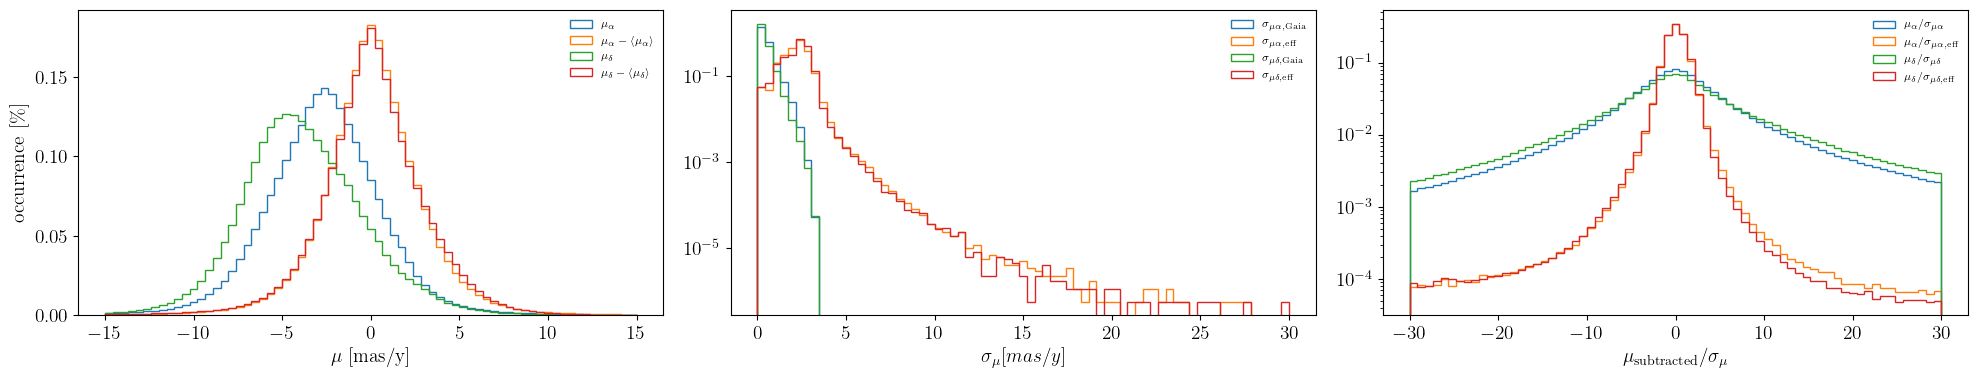

In [31]:
fig,ax = plt.subplots(1,3,figsize=(20,4))

xmax, nbins = 15, 70
ax[0].hist(stars_df['pmra'], bins=np.linspace(-xmax, xmax, nbins), log=False, density=True, histtype='step');
ax[0].hist(stars_df['pmra_sub'], bins=np.linspace(-xmax, xmax, nbins), log=False, density=True, histtype='step');
ax[0].hist(stars_df['pmdec'], bins=np.linspace(-xmax, xmax, nbins), log=False, density=True, histtype='step');
ax[0].hist(stars_df['pmdec_sub'], bins=np.linspace(-xmax, xmax, nbins), log=False, density=True, histtype='step');
ax[0].legend([r'$\mu_\alpha$', r'$\mu_\alpha - \langle \mu_\alpha \rangle$', '$\mu_\delta$', r'$\mu_\delta - \langle \mu_\delta \rangle$'], loc='upper right', fontsize = 8, frameon=False);
ax[0].set_xlabel(r'$\mu$ [mas/y]'); ax[0].set_ylabel(r'occurrence [$\%$]');
#ax.set_title(r'Velocity template for '+str(len(tau_list[map_count>min_count]))+' subsets', fontsize = 16);

xmax, nbins = 30, 70
ax[1].hist(stars_df['pmra_error'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
ax[1].hist(stars_df['pmra_eff_error'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
ax[1].hist(stars_df['pmdec_error'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
ax[1].hist(stars_df['pmdec_eff_error'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
ax[1].legend([r'$\sigma_{\mu\alpha, \mathrm{Gaia}}$', r'$\sigma_{\mu\alpha, \mathrm{eff}}$', r'$\sigma_{\mu\delta, \mathrm{Gaia}}$', r'$\sigma_{\mu\delta, \mathrm{eff}}$'], 
             loc='upper right', fontsize = 8, frameon=False);
ax[1].set_xlabel(r'$\sigma_\mu [mas/y]$'); #ax[1].set_ylabel(r'occurrence [$\%$]');

xmax, nbins = 30, 70
ax[2].hist(stars_df['pmra_sub']/stars_df['pmra_error'], bins=np.linspace(-xmax, xmax, nbins), log=True, density=True, histtype='step');
ax[2].hist(stars_df['pmra_sub']/stars_df['pmra_eff_error'], bins=np.linspace(-xmax, xmax, nbins), log=True, density=True, histtype='step');
ax[2].hist(stars_df['pmdec_sub']/stars_df['pmdec_error'], bins=np.linspace(-xmax, xmax, nbins), log=True, density=True, histtype='step');
ax[2].hist(stars_df['pmdec_sub']/stars_df['pmdec_eff_error'], bins=np.linspace(-xmax, xmax, nbins), log=True, density=True, histtype='step');
ax[2].legend([r'$\mu_{\alpha}/\sigma_{\mu\alpha}$', r'$\mu_{\alpha}/\sigma_{\mu\alpha, \mathrm{eff}}$', 
              r'$\mu_{\delta}/\sigma_{\mu\delta}$', r'$\mu_{\delta}/\sigma_{\mu\delta, \mathrm{eff}}$'], loc='upper right', fontsize = 8, frameon=False);
ax[2].set_xlabel(r'$\mu_\mathrm{subtracted}/\sigma_\mu$'); #ax[2].set_ylabel(r'occurrence [$\%$]');

plt.tight_layout()
#fig.savefig(FigDir+'pm_stats.pdf')

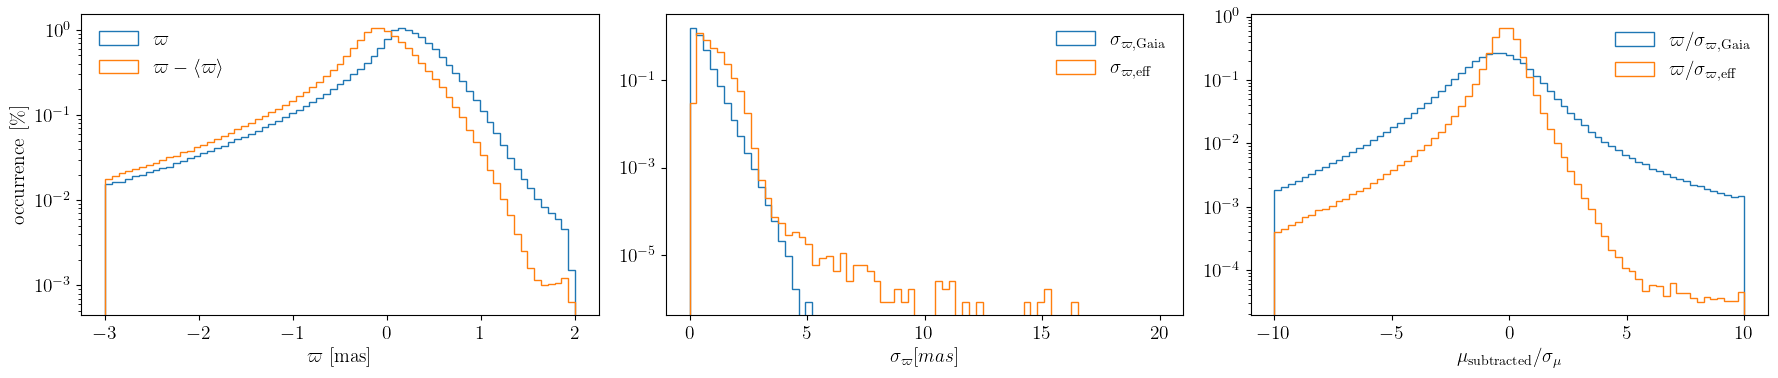

In [33]:
fig,ax = plt.subplots(1,3,figsize=(18,4))
font_size = 14

xmin, xmax, nbins = -3, 2, 70
ax[0].hist(stars_df['parallax'], bins=np.linspace(xmin, xmax, nbins), log=True, density=True, histtype='step');
ax[0].hist(stars_df['parallax_sub'], bins=np.linspace(xmin, xmax, nbins), log=True, density=True, histtype='step');
ax[0].legend([r'$\varpi$', r'$\varpi - \langle \varpi \rangle$'], loc='upper left', fontsize = font_size, frameon=False);
ax[0].set_xlabel(r'$\varpi$ [mas]'); ax[0].set_ylabel(r'occurrence [$\%$]');
#ax.set_title(r'Velocity template for '+str(len(tau_list[map_count>min_count]))+' subsets', fontsize = 16);

xmax, nbins = 20, 70
ax[1].hist(stars_df['parallax_error'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
ax[1].hist(stars_df['parallax_eff_error'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
ax[1].legend([r'$\sigma_{\varpi, \mathrm{Gaia}}$', r'$\sigma_{\varpi, \mathrm{eff}}$'], loc='upper right', fontsize = font_size, frameon=False);
ax[1].set_xlabel(r'$\sigma_\varpi [mas]$'); #ax[1].set_ylabel(r'occurrence [$\%$]');

xmax, nbins = 10, 70
ax[2].hist(stars_df['parallax_sub']/stars_df['parallax_error'], bins=np.linspace(-xmax, xmax, nbins), log=True, density=True, histtype='step');
ax[2].hist(stars_df['parallax_sub']/stars_df['parallax_eff_error'], bins=np.linspace(-xmax, xmax, nbins), log=True, density=True, histtype='step');
ax[2].legend([r'$\varpi/\sigma_{\varpi, \mathrm{Gaia}}$', r'$\varpi/\sigma_{\varpi, \mathrm{eff}}$'], loc='upper right', fontsize = font_size, frameon=False);
ax[2].set_xlabel(r'$\mu_\mathrm{subtracted}/\sigma_\mu$'); #ax[2].set_ylabel('occurrence [%]');

plt.tight_layout()
#fig.savefig(FigDir+'pm_stats.pdf')

# Some tests on the properties of the selected sample

In [4]:
df_back = pd.read_csv('/Users/crimondino/Dropbox (PI)/MyLensVelocity2/data/pairs_background_new.csv')
df_fore = pd.read_csv('/Users/crimondino/Dropbox (PI)/MyLensVelocity2/data/pairs_foreground_new.csv')
len(df_back), len(df_fore)

(4057114, 4057114)

In [4]:
chunksize = 10 ** 6
df_pairs = pd.read_csv(DataDir+'all_pairs.csv.gz', compression = 'gzip', chunksize=chunksize).get_chunk()

## Number density

In [28]:
chunk = pd.read_csv(DataDir+'all_pairs.csv.gz', compression = 'gzip', chunksize=chunksize)

In [31]:
chunk.get_chunk(2*10**6)

,source_id_fg,ra_fg,dec_fg,ra_error_fg,dec_error_fg,ra_dec_corr_fg,pmra_fg,pmdec_fg,pmra_error_fg,pmdec_error_fg,...,parallax_error_bg,ecl_lon_bg,ecl_lat_bg,phot_g_mean_mag_bg,accel_ra_bg,accel_ra_error_bg,accel_dec_bg,accel_dec_error_bg,l_bg,b_bg
10,262443977229440,45.939004,1.567216,0.014281,0.014527,0.144787,-26.279832,-9.960491,0.018196,0.017301,...,0.774860,43.940694,-15.108065,18.416502,NaN,NaN,NaN,NaN,176.258617,-47.137488
11,288759241271680,44.368005,0.812851,0.246849,0.235677,-0.126827,28.824193,-24.249587,0.308971,0.278783,...,0.547204,42.156524,-15.372719,19.860388,NaN,NaN,NaN,NaN,175.406584,-48.783053
12,305118772394112,44.040232,0.905647,0.048658,0.039883,-0.054103,22.907620,17.915429,0.066752,0.050114,...,0.288122,41.860628,-15.188039,18.767841,NaN,NaN,NaN,NaN,174.954663,-48.947981
13,308623465731200,44.348299,0.971618,0.014088,0.011823,-0.098262,-46.425016,-46.720098,0.016780,0.013950,...,0.123441,42.185843,-15.215867,15.857754,NaN,NaN,NaN,NaN,175.216791,-48.684400
14,338585157574912,44.547383,1.250921,0.015150,0.014440,0.020661,4.543681,-0.428888,0.018230,0.017081,...,0.199824,42.468112,-15.007998,17.428165,NaN,NaN,NaN,NaN,175.134308,-48.346045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000005,2005482412780019584,332.997154,54.656135,0.181694,0.214383,-0.077561,-0.678404,-1.832355,0.364363,0.231334,...,0.130424,9.201399,58.524511,18.106700,NaN,NaN,NaN,NaN,101.162571,-1.331604
2000006,2005482412789050880,333.002209,54.669759,0.141567,0.148338,-0.091639,-2.738451,-1.955603,0.176792,0.183034,...,0.272362,9.223543,58.532598,18.587902,NaN,NaN,NaN,NaN,101.172902,-1.321993
2000007,2005482412789056768,332.997694,54.655861,0.015142,0.014922,-0.181600,-1.066139,-1.051674,0.018401,0.017840,...,0.130424,9.201399,58.524511,18.106700,NaN,NaN,NaN,NaN,101.162571,-1.331604
2000008,2005482447149050240,333.028981,54.683026,0.057097,0.061563,-0.143171,-2.493164,-2.671198,0.071610,0.067103,...,0.067297,9.261250,58.532271,17.202370,NaN,NaN,NaN,NaN,101.192445,-1.319580


In [2]:
chunksize = 10 ** 6

TextFileReader = pd.read_csv(DataDir+'all_pairs.csv.gz', compression = 'gzip', chunksize=chunksize)
TextFileReader

In [11]:
fg_q_pix = []

for chunk_number, chunk in tqdm(enumerate(TextFileReader)):
    fg_q_pix.extend(hp.ang2pix(nside, chunk['l_fg'], chunk['b_fg'], lonlat=True))

    # some code here, if needed
    #pass

print("Total number of chunks is", chunk_number+1)

61it [06:36,  6.50s/it]

Total number of chunks is 61


In [16]:
map_count = np.bincount(fg_q_pix)

In [17]:
len(map_count), hp.nside2npix(nside)

(12288, 12288)

In [21]:
map_count = np.bincount(fg_q_pix)
if len(map_count)<hp.nside2npix(nside):
    print('si')
    map_count = np.concatenate((map_count, np.zeros(hp.nside2npix(nside)-len(map_count))))
map_count.shape

si


(3072,)

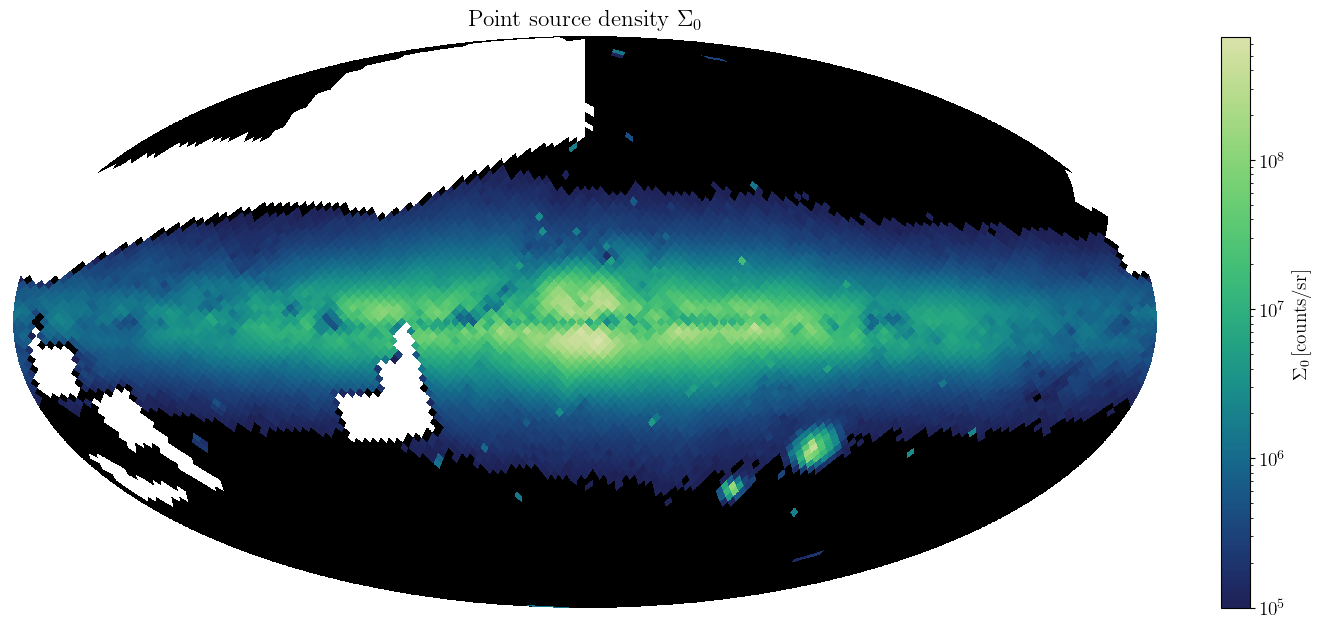

In [39]:
map = map_count/(np.sqrt(4*np.pi / npix)**2)
map_min = 10**5 #1e-3 * np.max(map); 
map_max = np.max(map); #print(np.mean(map), map_min, map_max)
cmap = sns.cubehelix_palette(start = 0.25, hue = 1.5, rot = -2/3, reverse = True, as_cmap=True)
#cmap.set_under(cmap(0)); cmap.set_bad(cmap(0)); cmap.set_over(cmap(1));
cmap.set_under('black'); cmap.set_over('black')
plt.subplots(1,1,figsize=(16,8))
hp.mollview(map, title=r"Point source density $\Sigma_0$", cmap=cmap, cbar=None, 
            bgcolor='black',badcolor='white',min=map_min,max=map_max,
            xsize=5000,hold=True, norm=mpl.colors.LogNorm(vmin=map_min,vmax=map_max))
fig = plt.gcf(); ax = plt.gca(); image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\Sigma_0 \, [\mathrm{counts/sr}]$')
#fig.savefig('source_density.pdf',figsize=(8,6),bbox_extra_artists=(image,),bbox_inches='tight',dpi=300,)

## Magnitude of the impact parameter

In [2]:
chunksize = 10 ** 6

TextFileReader = pd.read_csv(DataDir+'all_pairs.csv.gz', compression = 'gzip', chunksize=chunksize)

In [3]:
b_il_norm = []

for chunk_number, chunk in tqdm(enumerate(TextFileReader)):
    b_il_norm.extend(fn_angular_sep_scalar(chunk['ra_fg'].to_numpy()*degree, chunk['dec_fg'].to_numpy()*degree, 
                                           chunk['ra_bg'].to_numpy()*degree, chunk['dec_bg'].to_numpy()*degree)/arcsec)

    # some code here, if needed
    #pass

print("Total number of chunks is", chunk_number+1)

62it [06:36,  6.39s/it]

Total number of chunks is 62


In [4]:
len(b_il_norm)

61408993

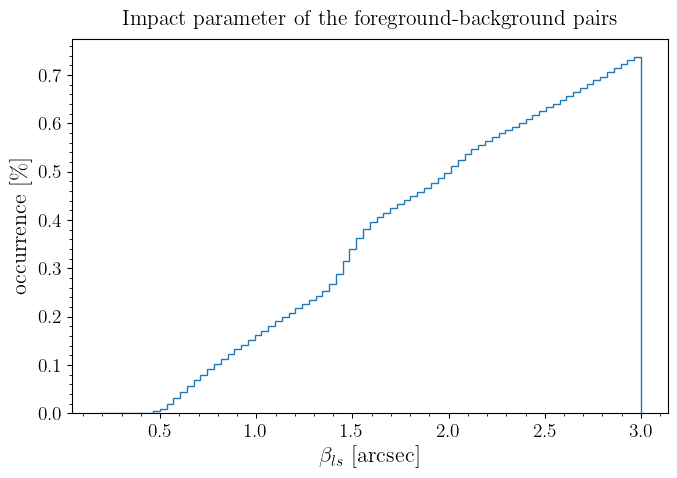

In [5]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

ax.minorticks_on()

ax.hist(b_il_norm, bins=80, log=False, density=True, histtype='step');
ax.set_title('Impact parameter of the foreground-background pairs', pad=10, fontsize=15.5)
ax.set_xlabel(r'$\beta_{ls}$ [arcsec]', fontsize=16); ax.set_ylabel(r'occurrence [$\%$]', fontsize=16);

fig.tight_layout()
#fig.savefig(FigDir+'Impact_param_histo.pdf')

In [18]:
### Angular distance between the foreground and background stars
#b_il_norm = fn_angular_sep_scalar(df_fore['ra'].to_numpy()*degree, df_fore['dec'].to_numpy()*degree, 
#                                  df_back['ra'].to_numpy()*degree, df_back['dec'].to_numpy()*degree)/arcsec

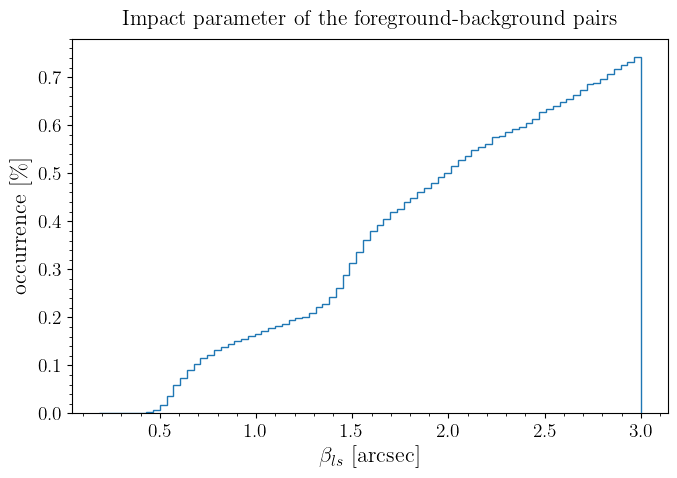

In [24]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

ax.minorticks_on()

ax.hist(b_il_norm, bins=80, log=False, density=True, histtype='step');
ax.set_title('Impact parameter of the foreground-background pairs', pad=10, fontsize=15.5)
ax.set_xlabel(r'$\beta_{ls}$ [arcsec]', fontsize=16); ax.set_ylabel(r'occurrence [$\%$]', fontsize=16);

fig.tight_layout()
#fig.savefig(FigDir+'Impact_param_histo.pdf')

## Anisotropy of the impact parameter

In [25]:
### Impact parameter and unit vector in the direction of the impact parameter
b_il = fn_angular_sep(df_fore['ra'].to_numpy()*degree, df_fore['dec'].to_numpy()*degree, 
                      df_back['ra'].to_numpy()*degree, df_back['dec'].to_numpy()*degree)
b_il_norm = np.sqrt(b_il[:, 0]**2+b_il[:, 1]**2)
b_il_hat = np.array([b_il[:, 0]/b_il_norm, b_il[:, 1]/b_il_norm]).T 

In [27]:
### Lens velocity unit vector
vl_vec = np.array([df_fore['pmra'].to_numpy(), df_fore['pmdec'].to_numpy()]).T
vl_norm = np.sqrt(vl_vec[:, 0]**2 + vl_vec[:, 1]**2)
vl_hat = np.array([vl_vec[:, 0]/vl_norm, vl_vec[:, 1]/vl_norm]).T 

In [42]:
### Angle between the impact parameter and the velocity unit vector
cos_theta = b_il_hat[:,0]*vl_hat[:,0] + b_il_hat[:,1]*vl_hat[:,1]
theta = np.arccos(cos_theta)

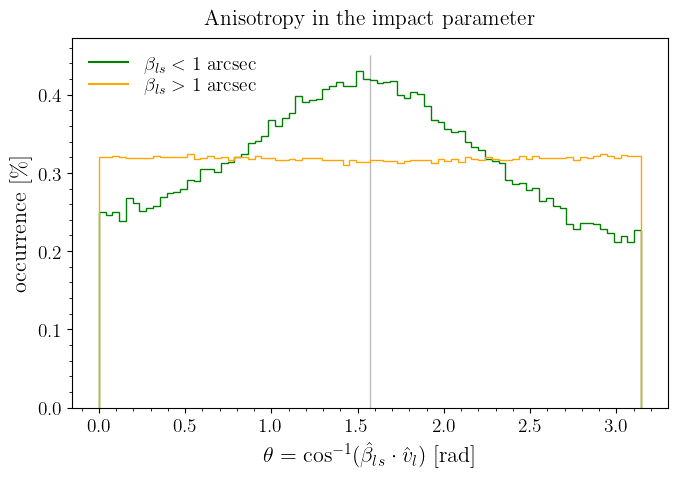

In [67]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist = ['green', 'orange', 'firebrick']
beta_th = 1

ax.minorticks_on()

ax.hist(theta[b_il_norm/arcsec < beta_th], bins=80, log=False, density=True, histtype='step', color=colorlist[0]);
ax.hist(theta[b_il_norm/arcsec >= beta_th], bins=80, log=False, density=True, histtype='step', color=colorlist[1]);
#ax.hist(theta[b_il_norm/arcsec >= beta_th], bins=80, log=False, density=True, histtype='step', color=colorlist[2]);
ax.set_title('Anisotropy in the impact parameter', pad=10, fontsize=15.5)
ax.set_xlabel(r'$\theta = \cos^{-1} (\hat{\beta}_{ls} \cdot \hat{v}_{l})$ [rad]', fontsize=16); ax.set_ylabel(r'occurrence [$\%$]', fontsize=16);

p = [plt.plot([0, 3], [0, 0], color=colorlist[i])[0] for i in range(2)] 
ax.legend(p, [r'$\beta_{ls} < '+str(beta_th)+' $ arcsec', r'$\beta_{ls} > '+str(beta_th)+' $ arcsec'], loc='upper left', frameon=False, labelspacing=0.2, fontsize=14);
[p[i].set_visible(False) for i in range(len(p))]

ax.vlines(math.pi/2, 0, 0.45, color='grey', linewidth = 1, alpha=0.5)

fig.tight_layout()
#fig.savefig(FigDir+'Impact_param_anisotropy.pdf')

# Template evaluation

In [ ]:
df_back = pd.read_csv(DataDir+'pairs_background_w_st.csv')
df_fore = pd.read_csv(DataDir+'pairs_foreground.csv')

In [ ]:
### Computing the weights
inv_cov_pm = np.linalg.inv(fn_cov_pm_eff(df_back))

In [ ]:
### Computing tau proper motion
tau_obs = 2.833*Year
fn_tau_mu(df_fore, df_back, inv_cov_pm, tau_obs, tau_max=False, matched_filter=fn_dipole_mf, rot_angle=False, quiet=True)